In [1]:
# load modules

import os
import numpy as np 
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from pysersic.results import plot_image, parse_multi_results, plot_residual
from pysersic import check_input_data
from pysersic.priors import SourceProperties, autoprior
from pysersic import FitSingle, FitMulti, PySersicMultiPrior
from pysersic.loss import student_t_loss_free_sys
from pysersic.rendering import HybridRenderer
from pysersic.multiband import FitMultiBandPoly

import jax
import jax.numpy as jnp
from jax.random import (
    PRNGKey,  # Need to use a seed to start jax's random number generation
)

import sep

from pysersic.loss import student_t_loss

import corner 

import asdf

import arviz as az

from sedpy import observate 

from astropy.modeling.models import Sersic1D
from astropy.visualization import make_lupton_rgb
from astropy.cosmology import Planck18 as cosmo



d:\Programs\Anaconda\envs\enso\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define path
path_wdir = r"D:\Programming\Cambridge\Enso Data"
path_fig = os.path.join(path_wdir, '191250_')

# define filter list
filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]
filterlist = observate.load_filters(["jwst_" + f for f in filter_list])

# define redshift
redshift = 5.3
pix_scale = 0.03  # from .fits header
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
# print rest-wavelength
# print(np.array([filterlist[1:][ii].wave_effective/1e4 for ii in range(len(band_list))])/(1+redshift))    #name 'band_list' is not defined



In [3]:
# check wlengths and create custom band list as alternative to full filter list
filterlist[0].wave_effective

8982.436421837761

In [4]:
band_list = filter_list[:]
wv_list = np.array([filterlist[:][ii].wave_effective/1e4 for ii in range(len(band_list))])
wv_list

array([0.89824364, 1.14859202, 1.49442228, 1.84236203, 1.97811383,
       2.09374694, 2.76120868, 3.54834844, 4.07932817, 4.37878307])

In [5]:
wv_list/(1+redshift)

array([0.14257836, 0.18231619, 0.23720989, 0.29243842, 0.31398632,
       0.33234078, 0.43828709, 0.56322991, 0.64751241, 0.69504493])

In [6]:
def load_data(filter, plot=False):

    '''
    Loading the data
    
    The 4 needed inputs to perform a fit are
     - im: the image itself
     - mask: a mask indicating pixels which should not be included in the fit
     - sig: a map of pixel uncertainties 
     - psf: a map of the PSF (for now, only one psf can be used).
    '''

    # load image data
    fname = os.path.join(path_wdir, '191250_cutouts', '191250_' + filter.upper() + '.fits')
    im = fits.getdata(fname, 'SCI')
    wht = fits.getdata(fname, 'WHT')
    ycen, xcen = 100, 100
    im = im[xcen-22:xcen+28, ycen-25:ycen+25]
    wht = wht[xcen-22:xcen+28, ycen-25:ycen+25]
    mask = np.zeros(im.shape)
    sig = 0.01/np.sqrt(np.abs(wht)) + 0.1*np.sqrt(np.abs(im))
    sig = 0.1*np.sqrt(np.abs(im))
    header = fits.getheader(fname, 'SCI')
    
    # load the PSF data
    PSF_large = fits.getdata(os.path.join(path_wdir, 'mpsf_gds', 'mpsf_' + filter.lower() + '.fits'))
    cen = int(0.5*PSF_large.shape[0])
    psf = PSF_large[cen-18:cen+19, cen-18:cen+19]
    psf /= np.sum(psf)
    psf = psf.astype(float)

    if plot:
        # plot data
        fig, ax = plot_image(im, mask, sig, psf)
        plt.show()

    # check data
    if check_input_data(data=im, rms=sig, psf=psf, mask=mask):
        print("data looks good!")
    else:
        print("data looks bad!")

    return(im, mask, sig, psf)



"FitMultiBandPoly"  uses a polynomial to “link” the parameters across wavelength.  
Next we must decide which parameters we want to be ‘linked’. For these parameters pysersic will parameterize them with a polynomial as a function of wavelength.

### MComp Test, Single Filter

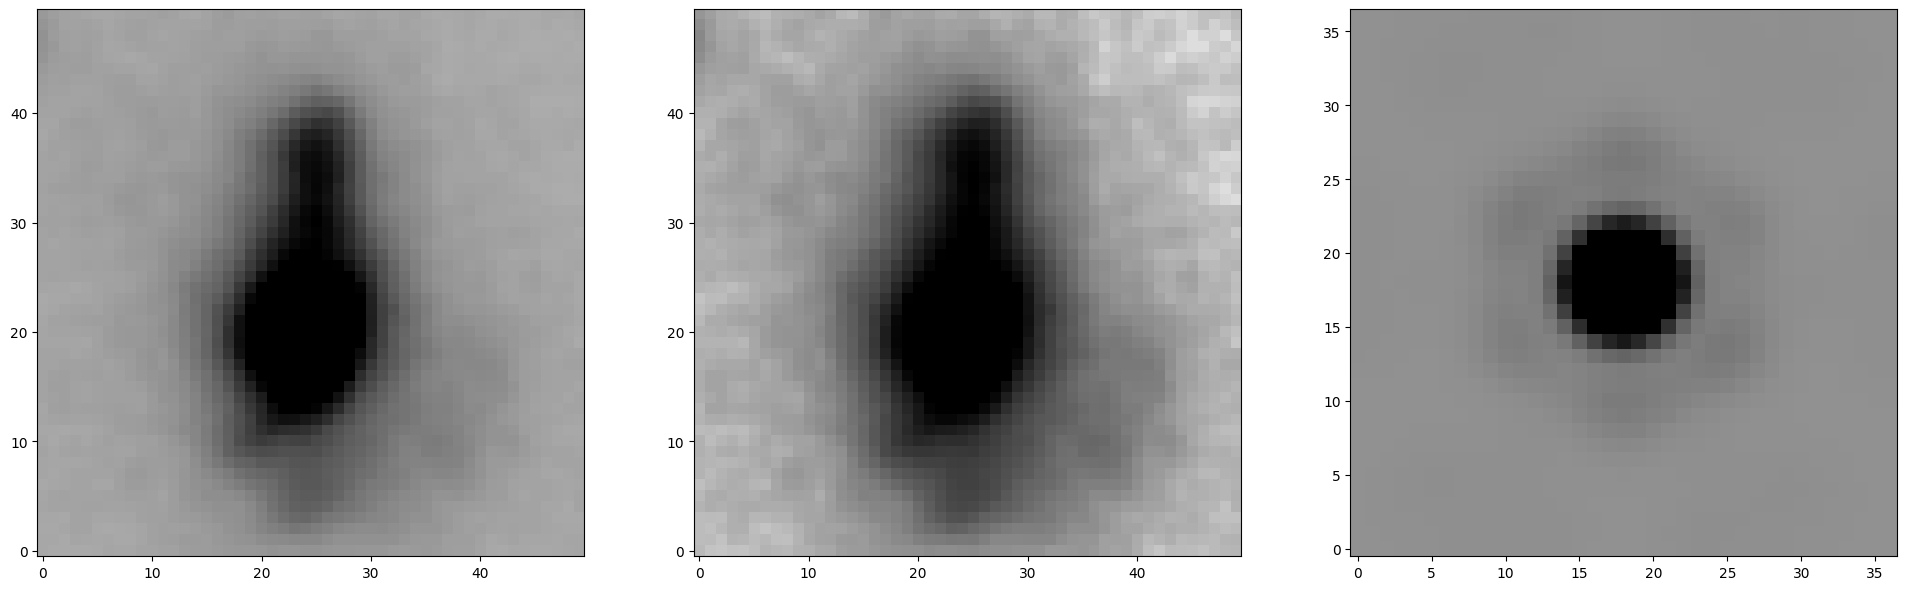

data looks good!


In [7]:
# test on single filter
im, mask, sig, psf = load_data(filter='f444w', plot=True)

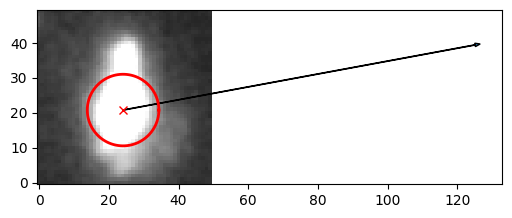

In [8]:
props = SourceProperties(im, mask=mask)
props.visualize();

In [9]:
from pysersic.priors import estimate_sky
med_sky, std_sky, n_pix = estimate_sky(im, mask)
sky_guess = med_sky
sky_guess_err = 2.* std_sky / np.sqrt(n_pix) # Use twice the error on the mean as the prior width
print(sky_guess)
print(sky_guess_err)

0.008379591628909111
0.00036741111840452853


1st Step: Define sources and make position & flux estimates.
============

In [10]:
# create a dictionary of 3/4 sources: central sersic region, point source,
# and two northern clumps.
to_pysersic = {}

# to_pysersic['flux'] = [10, 5, 5]
# to_pysersic['x'] = [24.0, 25.0, 26.0]
# to_pysersic['y'] = [21.0, 25.0, 40.0]
# to_pysersic['r'] = [8.0, 1.5, 2.0]
# to_pysersic['type'] = ['sersic', 'pointsource', 'sersic']

# (with 2 northern clumps:)
to_pysersic['flux'] = [10, 5, 5]
to_pysersic['x'] = [24.0, 25.0, 26.0]
to_pysersic['y'] = [21.0, 25.0, 40.0]
to_pysersic['r'] = [8.0, 1.5, 2.0]
to_pysersic['type'] = ['sersic', 'pointsource', 'sersic']

to_pysersic

{'flux': [10, 5, 5],
 'x': [24.0, 25.0, 26.0],
 'y': [21.0, 25.0, 40.0],
 'r': [8.0, 1.5, 2.0],
 'type': ['sersic', 'pointsource', 'sersic']}

In [14]:
# transfer the sources into a single multiprior object
mp = PySersicMultiPrior(catalog = to_pysersic, sky_type='none')
print(mp)

PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 1.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 1.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 8.00, sigma = 5.66, between: 0.50 -> inf
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 25.00, sigma = 1.00
yc_1 ---  Normal w/ mu = 25.00, sigma = 1.00
flux_1 ---  Normal w/ mu = 5.00, sigma = 4.47
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 1.00
yc_2 ---  Normal w/ mu = 40.00, sigma = 1.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.83, between: 0.50 -> inf
n_2 ---  Uniform between: 0.65 -> 8.00
ellip_2 ---  Uniform between: 0.00 -> 0.90
theta_2

In [15]:
# need a 'catalog' of each source/prior in the image:

# core (Component 0) # r = 8, flux = 20
# mp.set_uniform_prior('n_0', 0.3, 4.0)   
mp.set_truncated_gaussian_prior('r_eff_0', 7.5, 4.0, 2.0, 10.0) # based off individual fits
# mp.set_uniform_prior('xc_0', 23.0, 26.0) # Position in x for source
mp.set_gaussian_prior('xc_0', 24.0, 5.0)
# mp.set_uniform_prior('yc_0', 20.0, 22.0) # Position in y for source
mp.set_gaussian_prior('yc_0', 21.0, 5.0)

# Point Source 1: Bright psource; r = 1.5, flux = 10
mp.set_gaussian_prior('xc_1', 27.0, 5)  # Position in x for source
mp.set_gaussian_prior('yc_1', 23.0, 5)  # Position in y for source
# flux_1 --- Normal w/ mu = 5, sigma = 5
mp.set_truncated_gaussian_prior('flux_1', 5.0, 4.7, 0.0, 100) # Flux for point source
# mp.set_uniform_prior('flux', 1.0, 50.0) # Flux for point source


# Source 2: Northernmost clump; r = 2, flux = 8

mp.set_gaussian_prior('xc_2', 26.0, 7.0)
mp.set_gaussian_prior('yc_2', 35.0, 7.0)
mp.set_truncated_gaussian_prior('r_eff_2', 2.0, 2.0, 0.5, 5.0)
# mp.set_gaussian_prior('flux_3', 5.0, 5.0) # Flux for point source



mp

PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 5.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 5.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---  Uniform between: 0.65 -> 8.00
ellip_2 --- 

In [16]:
fm = FitMulti(data = im, rms= sig, psf = psf, prior= mp)
map_dict = fm.find_MAP(rkey = PRNGKey(99))

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 252/20000 [00:00<01:07, 293.29it/s, Round = 2,step_size = 5.0e-04 loss: -8.024e+03]


101.901955

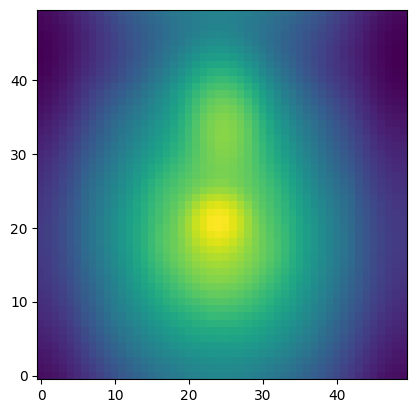

In [17]:
plt.imshow(np.log10(map_dict['model']), origin='lower');
np.sum(im)

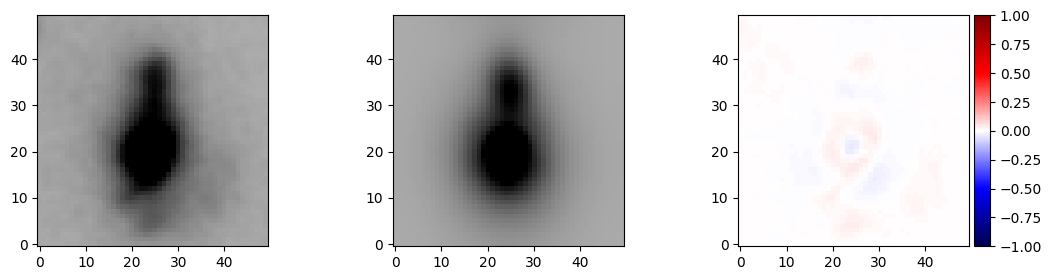

In [18]:
fig, ax = plot_residual(im,map_dict['model'],mask=mask,vmin=-1,vmax=1)

In [16]:
# fm.sample(rkey = PRNGKey(1000))

In [17]:
# comp1 = parse_multi_results(fm_res, 2)
# fig = comp1.corner(color='C0') 
# plt.show()
# mp

In [18]:
# summary = fm.sampling_results.summary()

# dict = {}
# for a, b in zip(summary.index, summary["mean"]):
#     dict[a] = b

# dict_0 = {'xc': dict['xc_0'], 
#     'yc': dict['yc_0'], 
#     'r_eff': dict['r_eff_0'], 
#     'n': dict['n_0'], 
#     'ellip': dict['ellip_0'], 
#     'flux': dict['flux_0'], 
#     'theta': dict['theta_0'],
#     'f_1': 1}

# dict_1 = {'xc': dict['xc_1'], 
#     'yc': dict['yc_1'], 
#     # 'r_eff': dict['r_eff_1'], 
#     # 'n': dict['n_1'], 
#     # 'ellip': dict['ellip_1'], 
#     'flux': dict['flux_1'], 
#     # 'theta': dict['theta_1'],
#     'f_1': 1}

# dict_2 = {'xc': dict['xc_2'], 
#     'yc': dict['yc_2'], 
#     'r_eff': dict['r_eff_2'], 
#     'n': dict['n_2'], 
#     'ellip': dict['ellip_2'], 
#     'flux': dict['flux_2'], 
#     'theta': dict['theta_2'],
#     'f_1': 1}    


# dict_3 = {'xc': dict['xc_3'], 
#     'yc': dict['yc_3'], 
#     'r_eff': dict['r_eff_3'], 
#     'n': dict['n_3'], 
#     'ellip': dict['ellip_3'], 
#     'flux': dict['flux_3'], 
#     'theta': dict['theta_3'],
#     'f_1': 1} 

# # dict.pop('sys_scatter')
# bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
# bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
# bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
# bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')

# bf_model = bf_model0 + bf_model1 + bf_model2 + bf_model3

# fig, ax = plot_residual(im, bf_model, mask = mask, vmin=-1, vmax=1)
# plt.show()

# # fm.sampling_results.save_result(os.path.join(path_wdir, 'Output', '3compfit' + '210m' + '.asdf'))


SVI Sampling
=====

In [19]:
fm.estimate_posterior(method = 'laplace', rkey = PRNGKey(999))
res_fm = fm.svi_results
res_fm.summary()

  2%|▏         | 384/20000 [00:00<00:48, 408.63it/s, Round = 2,step_size = 5.0e-04 loss: -8.033e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip_0,0.121,0.035,0.057,0.185,0.001,0.001,961.0,1071.0,NaN
ellip_2,0.181,0.089,0.044,0.350,0.003,0.002,1032.0,942.0,NaN
ellip_3,0.247,0.082,0.100,0.397,0.003,0.002,965.0,923.0,NaN
flux_0,50.018,2.481,45.541,54.733,0.078,0.056,1000.0,971.0,NaN
flux_1,5.130,4.114,0.373,12.202,0.128,0.090,1014.0,944.0,NaN
flux_2,19.935,3.933,11.834,26.607,0.120,0.085,1071.0,982.0,NaN
flux_3,14.160,0.838,12.599,15.666,0.025,0.018,1113.0,942.0,NaN
n_0,0.699,0.073,0.651,0.802,0.002,0.002,946.0,982.0,NaN
n_2,0.738,0.106,0.654,0.919,0.004,0.003,939.0,881.0,NaN
n_3,0.722,0.094,0.652,0.869,0.003,0.002,1062.0,1072.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


C:\Users\kings\AppData\Local\Temp\ipykernel_21160\519016473.py:45: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_21160\519016473.py:46: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_21160\519016473.py:47: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_21160\519016473.py:48: User

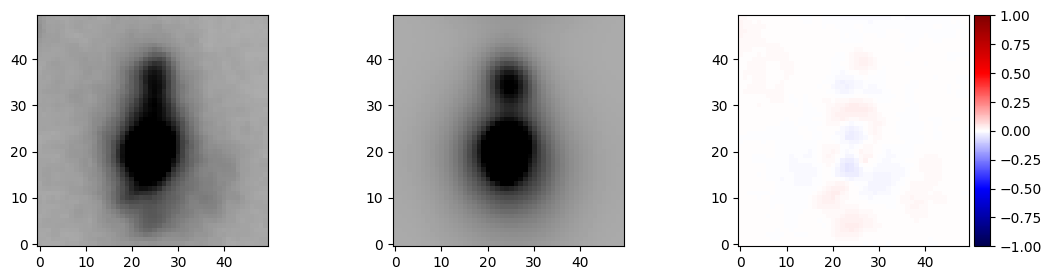

In [20]:
summary = res_fm.summary()

dict = {}
for a, b in zip(summary.index, summary["mean"]):
    dict[a] = b

dict_0 = {'xc': dict['xc_0'], 
    'yc': dict['yc_0'], 
    'r_eff': dict['r_eff_0'], 
    'n': dict['n_0'], 
    'ellip': dict['ellip_0'], 
    'flux': dict['flux_0'], 
    'theta': dict['theta_0'],
    'f_1': 1}

dict_1 = {'xc': dict['xc_1'], 
    'yc': dict['yc_1'], 
    # 'r_eff': dict['r_eff_1'], 
    # 'n': dict['n_1'], 
    # 'ellip': dict['ellip_1'], 
    'flux': dict['flux_1'], 
    # 'theta': dict['theta_1'],
    'f_1': 1}

dict_2 = {'xc': dict['xc_2'], 
    'yc': dict['yc_2'], 
    'r_eff': dict['r_eff_2'], 
    'n': dict['n_2'], 
    'ellip': dict['ellip_2'], 
    'flux': dict['flux_2'], 
    'theta': dict['theta_2'],
    'f_1': 1}    

# dict.pop('sys_scatter')
bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')

bf_model = bf_model0 + bf_model1 + bf_model2

fig, ax = plot_residual(im, bf_model, mask = mask, vmin=-1, vmax=1)
plt.show()

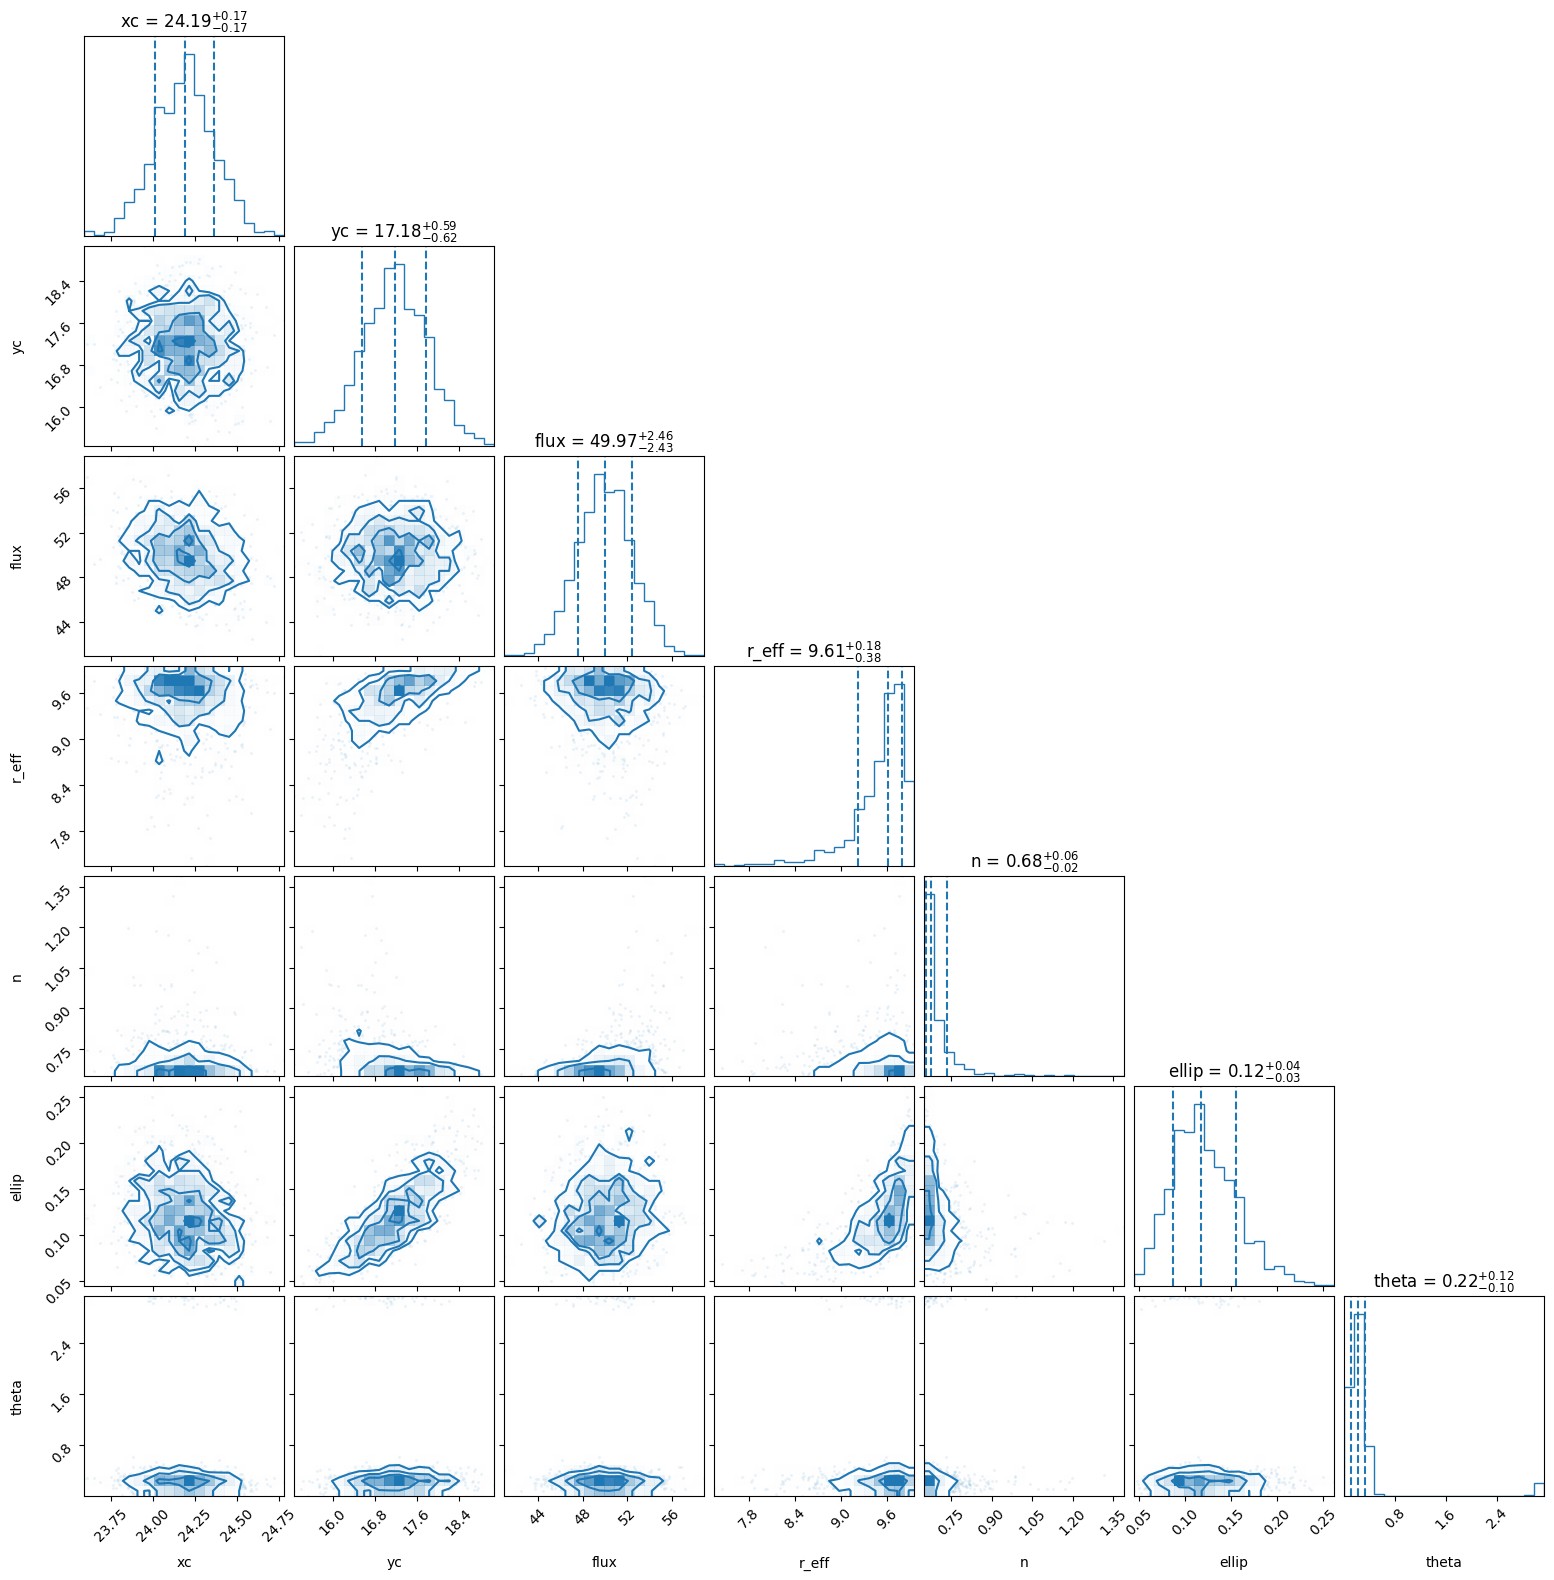

In [21]:
res_fm = fm.svi_results
comp0 = parse_multi_results(res_fm, 0)
fig = comp0.corner(color='C0') 
plt.show()

# res_fm.save_result(os.path.join(path_wdir, 'Output', '4compSVI_' + 'test' + '.asdf'))
    


## Individual bands, 3-component SVI
4 components: central one, close-to centre point source, and two components to the north. Not sure if a 5th component in the South should be attempted too. You probably have those components being somewhat constraint, for example regarding position and Sersic index.  \\

Using previous modelling results to initialize...

load data for filter F090W
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 251/20000 [00:00<01:01, 321.18it/s, Round = 2,step_size = 5.0e-04 loss: -9.964e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

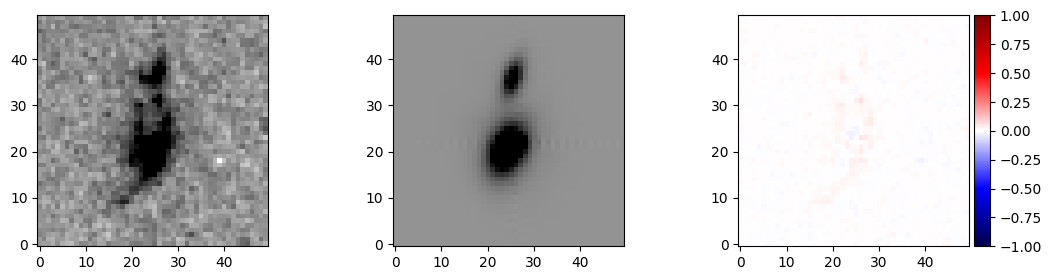

load data for filter F115W
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 255/20000 [00:00<00:59, 333.40it/s, Round = 2,step_size = 5.0e-04 loss: -9.593e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

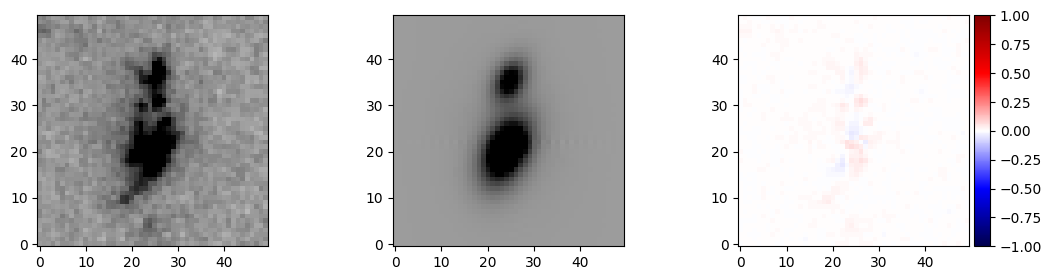

load data for filter F150W
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 251/20000 [00:00<01:16, 258.02it/s, Round = 2,step_size = 5.0e-04 loss: -9.473e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

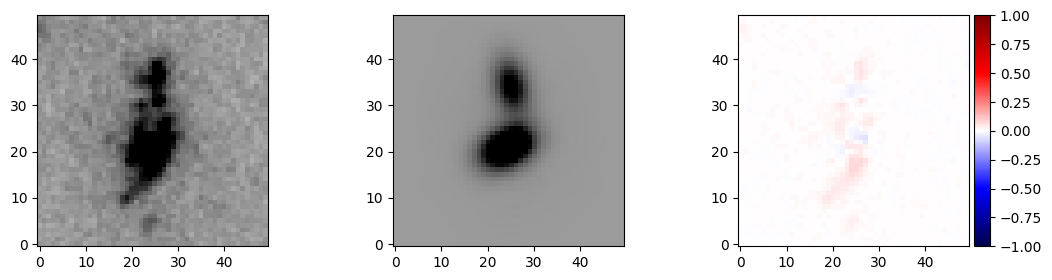

load data for filter F182M
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 276/20000 [00:00<00:59, 331.21it/s, Round = 2,step_size = 5.0e-04 loss: -9.120e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

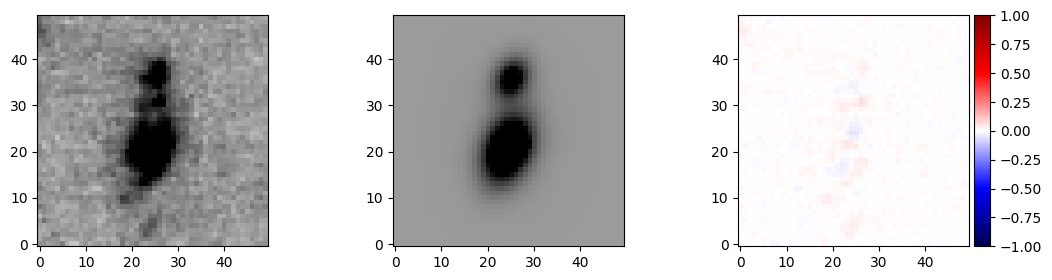

load data for filter F200W
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 252/20000 [00:00<01:01, 323.35it/s, Round = 2,step_size = 5.0e-04 loss: -9.486e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

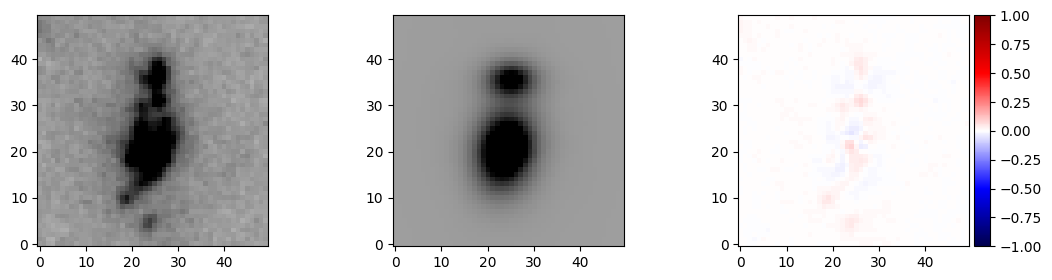

load data for filter F210M
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 251/20000 [00:00<01:18, 251.28it/s, Round = 2,step_size = 5.0e-04 loss: -8.655e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

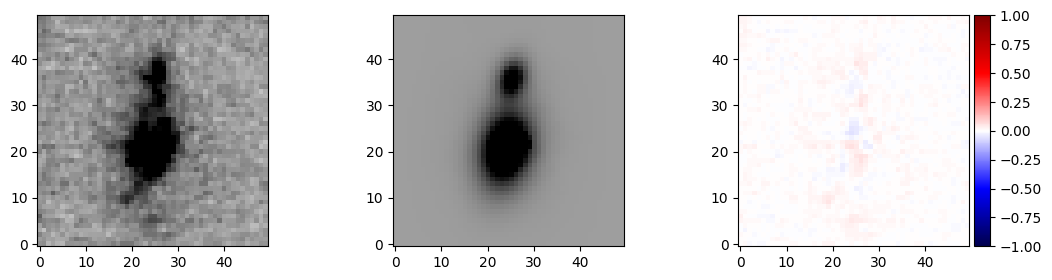

load data for filter F277W
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  2%|▏         | 345/20000 [00:01<00:58, 335.18it/s, Round = 2,step_size = 5.0e-04 loss: -8.787e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

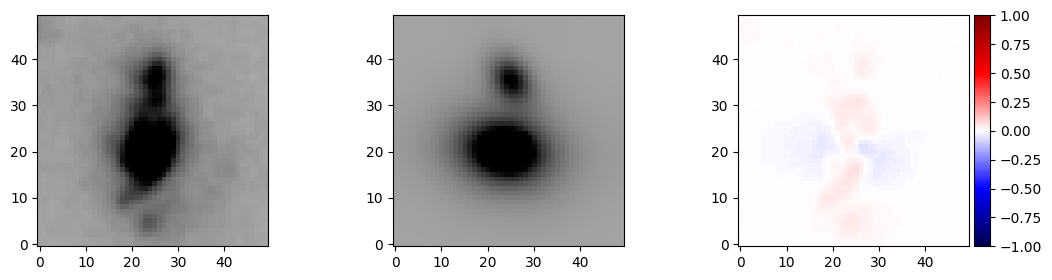

load data for filter F356W
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  2%|▏         | 448/20000 [00:01<00:52, 373.72it/s, Round = 2,step_size = 5.0e-04 loss: -8.531e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

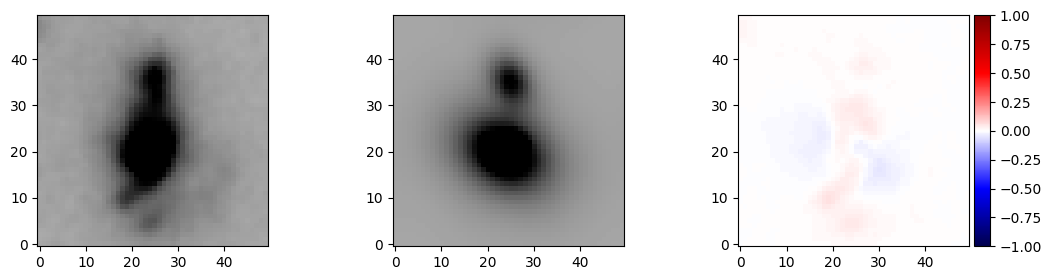

load data for filter F410M
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 269/20000 [00:00<01:07, 291.51it/s, Round = 2,step_size = 5.0e-04 loss: -7.844e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

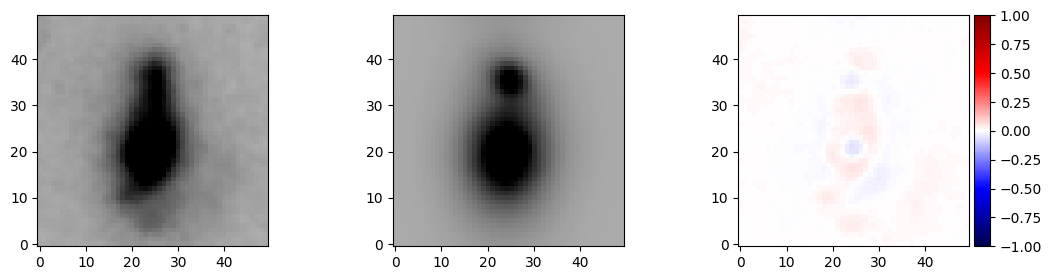

load data for filter F444W
data looks good!
PySersicMultiPrior containing 3 sources 
Source #0 of type - sersic:
---------------------------
xc_0 ---  Normal w/ mu = 24.00, sigma = 5.00
yc_0 ---  Normal w/ mu = 21.00, sigma = 5.00
flux_0 ---  Normal w/ mu = 10.00, sigma = 6.32
r_eff_0 ---  Truncated Normal w/ mu = 7.50, sigma = 4.00, between: 2.00 -> 10.00
n_0 ---  Uniform between: 0.65 -> 8.00
ellip_0 ---  Uniform between: 0.00 -> 0.90
theta_0 ---  Uniform between: 0.00 -> 6.28
Source #1 of type - pointsource:
--------------------------------
xc_1 ---  Normal w/ mu = 27.00, sigma = 3.00
yc_1 ---  Normal w/ mu = 23.00, sigma = 3.00
flux_1 ---  Truncated Normal w/ mu = 5.00, sigma = 4.70, between: 0.00 -> 100.00
Source #2 of type - sersic:
---------------------------
xc_2 ---  Normal w/ mu = 26.00, sigma = 7.00
yc_2 ---  Normal w/ mu = 35.00, sigma = 7.00
flux_2 ---  Normal w/ mu = 5.00, sigma = 4.47
r_eff_2 ---  Truncated Normal w/ mu = 2.00, sigma = 2.00, between: 0.50 -> 5.00
n_2 ---

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▏         | 260/20000 [00:00<00:50, 390.94it/s, Round = 2,step_size = 5.0e-04 loss: -8.006e+03]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_25844\2101524897.py:76: UserWarning: A JAX array is being set as static! This ca

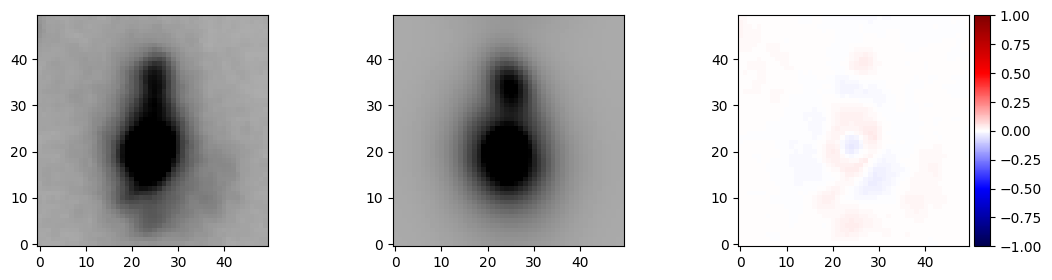

In [19]:
for ii_f in filter_list:

    print("=============================================================================")
    # load data
    print("load data for filter", ii_f.upper())
    im, mask, sig, psf = load_data(filter=ii_f)
    
    # get priors
    props = SourceProperties(im, mask=mask) # Optional mask
    mp = PySersicMultiPrior(catalog = to_pysersic, sky_type='none')
    # core (Component 0) # r = 8, flux = 20
    mp.set_truncated_gaussian_prior('r_eff_0', 7.5, 4.0, 2.0, 10.0) # based off individual fits
    mp.set_gaussian_prior('xc_0', 24.0, 5.0)
    mp.set_gaussian_prior('yc_0', 21.0, 5.0)

    # Point Source 1: Bright psource; r = 1.5, flux = 10
    mp.set_gaussian_prior('xc_1', 27.0, 3)  # Position in x for source
    mp.set_gaussian_prior('yc_1', 23.0, 3)  # Position in y for source
    mp.set_truncated_gaussian_prior('flux_1', 5.0, 4.7, 0.0, 100) # Flux for point source

    # # Source 2: Northern minor clump; r = 3, flux = 10
    mp.set_gaussian_prior('xc_2', 26.0, 7.0)
    mp.set_gaussian_prior('yc_2', 35.0, 7.0)
    mp.set_truncated_gaussian_prior('r_eff_2', 2.0, 2.0, 0.5, 5.0)
    
    print(mp)

    # setup fitter
    fm = FitMulti(data = im, rms= sig, psf = psf, prior= mp)

    # SVI   
    fm.estimate_posterior(method = 'laplace', rkey = PRNGKey(999))
    res_mp = fm.svi_results
    res_mp.summary()

    # # sampling
    # fitter.sample(rkey = PRNGKey(1000))
    # print(fitter.sampling_results.retrieve_param_quantiles(return_dataframe=True))

    summary = res_mp.summary()

    dict = {}
    for a, b in zip(summary.index, summary["mean"]):
        dict[a] = b

    dict_0 = {'xc': dict['xc_0'], 
        'yc': dict['yc_0'], 
        'r_eff': dict['r_eff_0'], 
        'n': dict['n_0'], 
        'ellip': dict['ellip_0'], 
        'flux': dict['flux_0'], 
        'theta': dict['theta_0'],
        'f_1': 1}

    dict_1 = {'xc': dict['xc_1'], 
        'yc': dict['yc_1'], 
        # 'r_eff': dict['r_eff_1'], 
        # 'n': dict['n_1'], 
        # 'ellip': dict['ellip_1'], 
        'flux': dict['flux_1'], 
        # 'theta': dict['theta_1'],
        'f_1': 1}

    dict_2 = {'xc': dict['xc_2'], 
        'yc': dict['yc_2'], 
        'r_eff': dict['r_eff_2'], 
        'n': dict['n_2'], 
        'ellip': dict['ellip_2'], 
        'flux': dict['flux_2'], 
        'theta': dict['theta_2'],
        'f_1': 1}    


    # dict.pop('sys_scatter')
    bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
    bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
    bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')

    bf_model = bf_model0 + bf_model1 + bf_model2

    fig, ax = plot_residual(im, bf_model, mask = mask, vmin=-1, vmax=1)
    plt.show()
    
    # plot corner
    # print("corner of", ii_f.upper())
    # fig = fm.sampling_results.corner(color='C0') 
    # plt.show()
    # print("=============================================================================")
    
    # save results
    res_fm = fm.svi_results
    # comp0 = parse_multi_results(res_fm, 0)
    res_fm.save_result(os.path.join(path_wdir, 'Output', '3compSVI_' + ii_f + '.asdf'))

### 3-Comp. SVI Multiband

MBand steps:
- load filters & wvlths
- create dicts for psf's, imgs, rms, and priors
- load data to dicts
- create fitter & result dicts
- load data to them (looping)

In [7]:
# applying custom priors to function fit:

# create a dictionary of 4 sources: central sersic region, point source,
# and two northern clumps.
to_pysersic = {}
to_pysersic['flux'] = [10, 5, 5]
to_pysersic['x'] = [24.0, 25.0, 26.0]
to_pysersic['y'] = [21.0, 25.0, 40.0]
to_pysersic['r'] = [8.0, 1.5, 2.0]
to_pysersic['type'] = ['sersic', 'pointsource', 'sersic']

# create dictionaries to store psf, img, rms, and prior for each band
psf_dict = {}
img_dict = {}
rms_dict = {}
prior_mcomp_dict = {}

# iterate through filters/bands, compiling dicts of psf, img, rms, and multi-component prior
# for each band
for j,band in enumerate(filter_list):
    # load data
    im, mask, sig, psf = load_data(filter=band)
    psf_dict[band] = psf
    img_dict[band] = im
    rms_dict[band] = sig

    # SourceProperties analyses the source image to determine properties
    # props = SourceProperties(im, mask=mask) # Optional mask

    # transfer the sources into a single multiprior object
    mp = PySersicMultiPrior(catalog = to_pysersic, sky_type='none')
    
    # core (Component 0) # r = 8, flux = 20
    # mp.set_uniform_prior('n_0', 0.3, 4.0)   
    mp.set_truncated_gaussian_prior('r_eff_0', 7.5, 4.0, 2.0, 10.0) # based off individual fits
    # mp.set_uniform_prior('xc_0', 23.0, 26.0) # Position in x for source
    mp.set_gaussian_prior('xc_0', 24.0, 5.0)
    # mp.set_uniform_prior('yc_0', 20.0, 22.0) # Position in y for source
    mp.set_gaussian_prior('yc_0', 21.0, 5.0)

    # Point Source 1: Bright psource; r = 1.5, flux = 10
    mp.set_gaussian_prior('xc_1', 27.0, 5)  # Position in x for source
    mp.set_gaussian_prior('yc_1', 23.0, 5)  # Position in y for source
    # flux_1 --- Normal w/ mu = 5, sigma = 5
    mp.set_truncated_gaussian_prior('flux_1', 5.0, 4.7, 0.0, 100) # Flux for point source
    # mp.set_uniform_prior('flux', 1.0, 50.0) # Flux for point source


    # Source 2: Northernmost clump; r = 2, flux = 8

    mp.set_gaussian_prior('xc_2', 26.0, 7.0)
    mp.set_gaussian_prior('yc_2', 35.0, 7.0)
    mp.set_truncated_gaussian_prior('r_eff_2', 2.0, 2.0, 0.5, 5.0)
    # mp.set_gaussian_prior('flux_3', 5.0, 5.0) # Flux for point source

    prior_mcomp_dict[band] = mp # store the prior for that band

    


data looks good!
data looks good!
data looks good!
data looks good!
data looks good!
data looks good!
data looks good!
data looks good!
data looks good!
data looks good!


In [8]:

# loop through and run fit in each of the 3 bands
fitter_dict = {}
ind_res_dict = {}

rkey = jax.random.PRNGKey(19)

for band in band_list:
    rkey,_ = jax.random.split(rkey, 2) # use different random number key for each run
    # multi component fit
    fitter_cur = FitMulti(
        data = img_dict[band],
        rms = rms_dict[band],
        psf = psf_dict[band],
        prior = prior_mcomp_dict[band],
        mask = mask.copy(),
        loss_func = student_t_loss_free_sys
    )
    print (f'Running fit - {band}')
    ind_res_cur = fitter_cur.estimate_posterior(rkey = rkey)
    ind_res_dict[band] = ind_res_cur.retrieve_med_std()
    fitter_dict[band] = fitter_cur

d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f090w


  1%|▏         | 251/20000 [00:00<00:32, 602.25it/s, Round = 2,step_size = 5.0e-04 loss: -9.465e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f115w


  2%|▏         | 436/20000 [00:00<00:42, 458.29it/s, Round = 2,step_size = 5.0e-04 loss: -9.109e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f150w


  1%|▏         | 261/20000 [00:00<00:34, 568.20it/s, Round = 2,step_size = 5.0e-04 loss: -9.110e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f182m


  1%|▏         | 254/20000 [00:00<00:37, 533.21it/s, Round = 2,step_size = 5.0e-04 loss: -8.660e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f200w


  1%|▏         | 256/20000 [00:00<00:35, 552.61it/s, Round = 2,step_size = 5.0e-04 loss: -8.982e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f210m


  1%|▏         | 252/20000 [00:00<00:37, 528.28it/s, Round = 2,step_size = 5.0e-04 loss: -8.247e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f277w


  1%|▏         | 264/20000 [00:00<00:36, 542.47it/s, Round = 2,step_size = 5.0e-04 loss: -8.223e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f356w


  1%|▏         | 252/20000 [00:00<00:35, 557.93it/s, Round = 2,step_size = 5.0e-04 loss: -7.960e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f410m


  1%|▏         | 251/20000 [00:00<00:46, 424.69it/s, Round = 2,step_size = 5.0e-04 loss: -7.338e+03]
d:\Programs\Anaconda\envs\enso\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f444w


  1%|▏         | 273/20000 [00:00<00:45, 431.88it/s, Round = 2,step_size = 5.0e-04 loss: -7.444e+03]


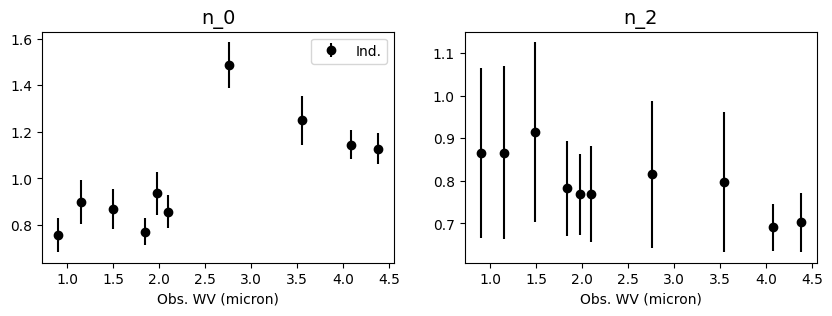

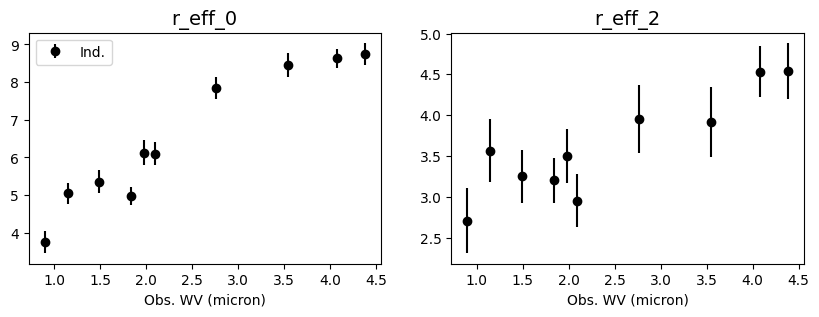

In [9]:
fig, axes = plt.subplots(1,2, figsize = (10,3))

for j,param in enumerate(['n_0', 'n_2']):
    ax = axes[j]

    med_ind = [ind_res_dict[b][param][0] for b in band_list]
    err_ind = [ind_res_dict[b][param][1] for b in band_list]
    ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
    ax.set_xlabel('Obs. WV (micron)')
    ax.set_title(param, fontsize = 14)
axes[0].legend()

fig, axes = plt.subplots(1,2, figsize = (10,3))

# for j,param in enumerate(['ellip_0', 'ellip_2', 
#                                'ellip_3']):
#     ax = axes[j]

#     med_ind = [ind_res_dict[b][param][0] for b in band_list]
#     err_ind = [ind_res_dict[b][param][1] for b in band_list]
#     ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
#     ax.set_xlabel('Obs. WV (micron)')
#     ax.set_title(param, fontsize = 14)
# axes[0].legend()

for j,param in enumerate(['r_eff_0', 'r_eff_2']):
    ax = axes[j]

    med_ind = [ind_res_dict[b][param][0] for b in band_list]
    err_ind = [ind_res_dict[b][param][1] for b in band_list]
    ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
    ax.set_xlabel('Obs. WV (micron)')
    ax.set_title(param, fontsize = 14)
axes[0].legend()


In [10]:
wv_list = np.array([filterlist[:][ii].wave_effective/1e4 for ii in range(len(filter_list))])

wv_to_save = np.linspace(min(wv_list),max(wv_list), num = 50)

# Joint fit - choose parameters to link across wavelength
MultiFitter = FitMultiBandPoly(fitter_list=[fitter_dict[b] for b in filter_list],
                               wavelengths=wv_list,
                               band_names= filter_list,
                               linked_params=['n_0', 'n_2', 'ellip_0', 'ellip_2', 
                               'r_eff_0', 'r_eff_2'],
                               const_params=['xc_0', 'xc_1', 'xc_2',
                                'yc_0', 'yc_1', 'yc_2', 'theta_0', 'theta_2'],
                               wv_to_save= wv_to_save,
                               poly_order = 2)
rkey,_ = jax.random.split(rkey,2)
multires = MultiFitter.estimate_posterior(method = 'svi-flow', rkey = rkey)

link_params = [f'{param}_{b}' for b in filter_list for param in ['n_0', 'n_2', 'ellip_0', 'ellip_2', 
                               'r_eff_0', 'r_eff_2']] # Look at posteriors of "linked" parameters
multi_res_dict = multires.retrieve_med_std()
az.summary(multires.idata, var_names=link_params)



  3%|▎         | 680/20000 [01:15<35:52,  8.98it/s, Round = 2,step_size = 5.0e-04 loss: -8.416e+04]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n_0_f090w,0.760,0.058,0.685,0.876,0.002,0.001,918.0,871.0,NaN
n_2_f090w,0.774,0.033,0.722,0.840,0.001,0.001,905.0,882.0,NaN
ellip_0_f090w,0.449,0.049,0.353,0.535,0.002,0.001,839.0,799.0,NaN
ellip_2_f090w,0.361,0.030,0.309,0.422,0.001,0.001,1039.0,955.0,NaN
r_eff_0_f090w,3.531,0.264,3.058,4.053,0.008,0.006,1005.0,785.0,NaN
r_eff_2_f090w,3.692,0.156,3.432,4.010,0.005,0.004,940.0,1059.0,NaN
n_0_f115w,0.758,0.050,0.687,0.858,0.002,0.001,897.0,848.0,NaN
n_2_f115w,0.822,0.037,0.756,0.891,0.001,0.001,846.0,850.0,NaN
ellip_0_f115w,0.437,0.040,0.351,0.502,0.001,0.001,816.0,827.0,NaN
ellip_2_f115w,0.350,0.025,0.306,0.396,0.001,0.001,1008.0,945.0,NaN


In [11]:
# import pandas as pd
# multires.summary().to_csv(os.path.join(path_wdir, 'Output', '3comp_MultiBand_SVI.csv'), index=True)

In [12]:
# df = pd.read_csv(f'D:\\Programming\\Cambridge\\Enso Data\\Output\\4comp_MultiBand_SVI.csv')
# df = df.rename(columns={'Unnamed: 0': "variables"})
# df.set_index('variables')

In [14]:

# link_params = [f'{param}_{b}' for b in filter_list for param in ['n_0', 'n_2', 'n_3', 'ellip_0', 'ellip_2', 
#                                'ellip_3', 'r_eff_0', 'r_eff_2', 'r_eff_3']] # Look at posteriors of "linked" parameters
# multi_res_dict = multires.retrieve_med_std()
# az.summary(multires.idata, var_names=link_params)
# # help(multires.save_result(os.path.join(path_wdir, 'Output', '4comp_MultiBand_SVI', '.asdf')))

In [15]:
multires.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip_0_at_wv[0],0.449,0.049,0.353,0.535,0.002,0.001,839.0,799.0,NaN
ellip_0_at_wv[1],0.445,0.046,0.357,0.529,0.002,0.001,832.0,722.0,NaN
ellip_0_at_wv[2],0.442,0.044,0.356,0.517,0.002,0.001,824.0,689.0,NaN
ellip_0_at_wv[3],0.438,0.042,0.355,0.509,0.001,0.001,818.0,711.0,NaN
ellip_0_at_wv[4],0.435,0.039,0.353,0.499,0.001,0.001,810.0,786.0,NaN
...,...,...,...,...,...,...,...,...,...
xc_1,26.528,0.109,26.341,26.753,0.003,0.002,1011.0,1072.0,NaN
xc_2,23.613,0.038,23.546,23.684,0.001,0.001,874.0,914.0,NaN
yc_0,34.890,0.144,34.616,35.141,0.005,0.003,931.0,976.0,NaN
yc_1,21.954,0.072,21.820,22.084,0.002,0.002,1043.0,981.0,NaN


In [141]:
# multires.idata

In [16]:
link_params = [f'{param}_{b}' for b in filter_list for param in ['n_0', 'n_2', 'ellip_0', 'ellip_2', 'r_eff_0', 'r_eff_2']]
flux_params = [f'{param}_{b}' for b in filter_list for param in ['flux_0', 'flux_1', 'flux_2']]
const_params = ['xc_0', 'xc_1', 'xc_2', 'yc_0', 'yc_1', 'yc_2', 'theta_0', 'theta_2']
summ_const = az.summary(multires.idata, var_names=link_params)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
C:\Users\kings\AppData\Local\Temp\ipykernel_11416\1829458547.py:44: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_11416\1829458547.py:45: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_11416\1829458547.py:46: Use

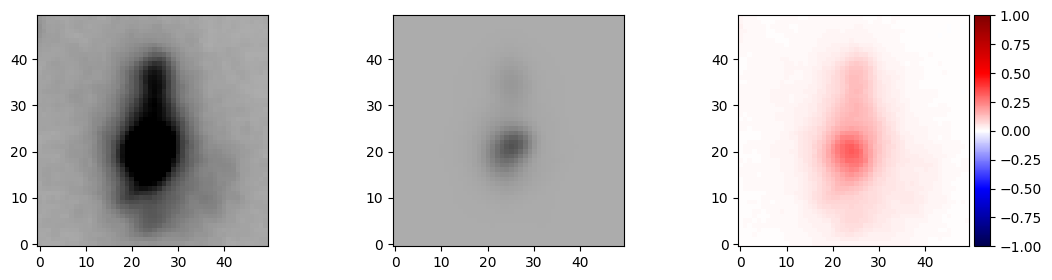

C:\Users\kings\AppData\Local\Temp\ipykernel_11416\1829458547.py:44: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')


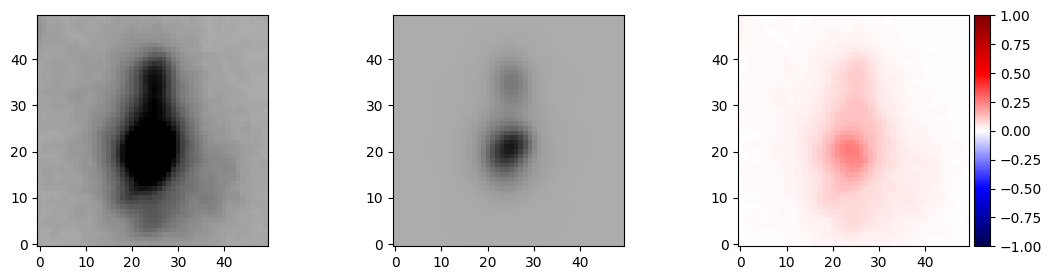

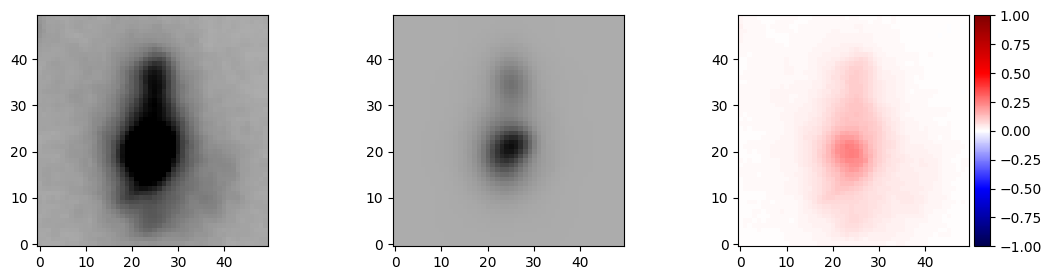

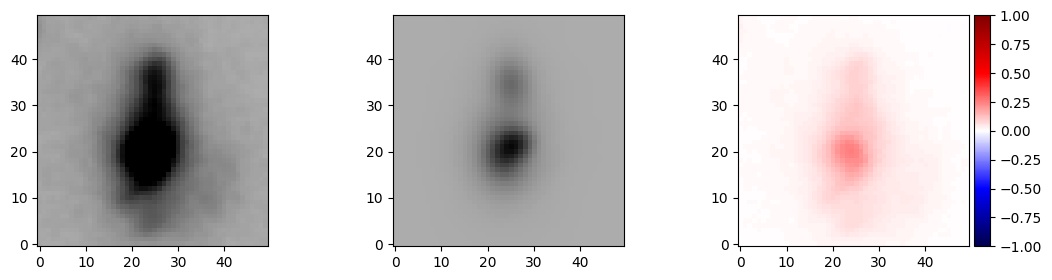

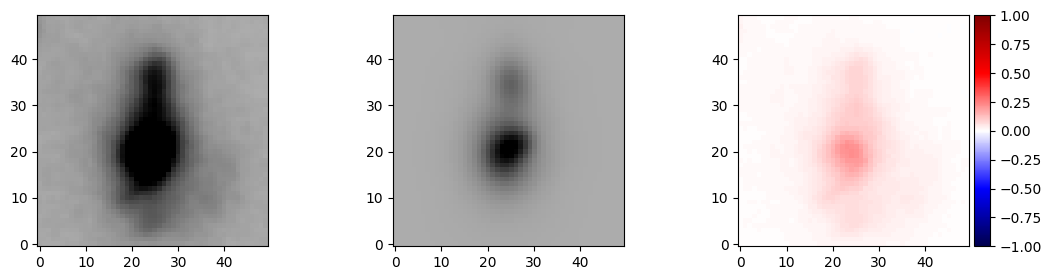

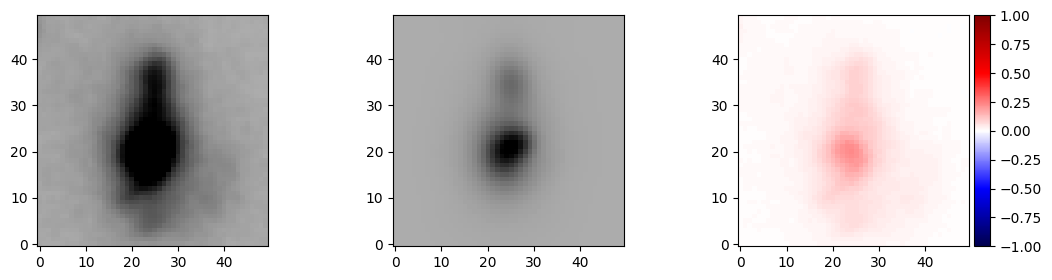

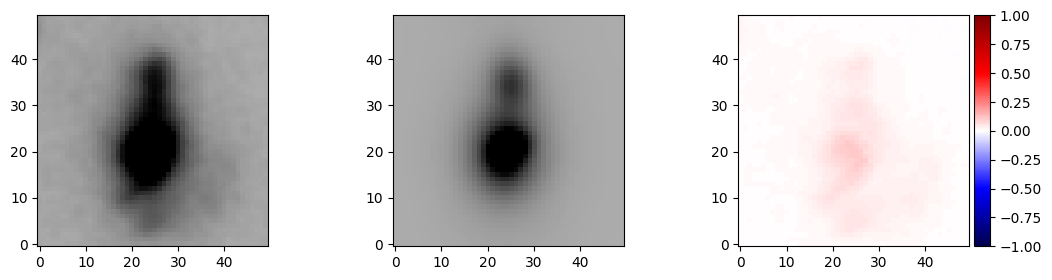

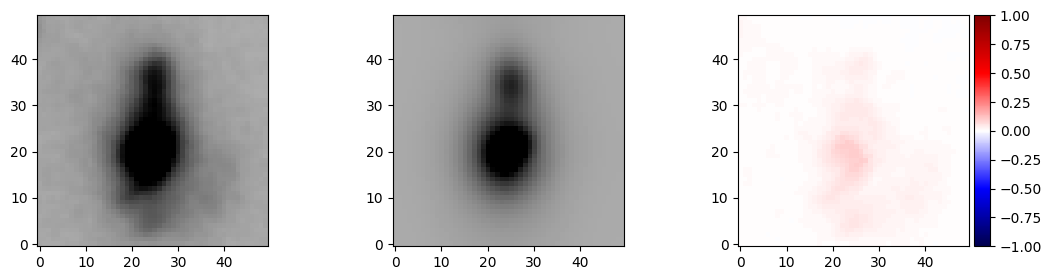

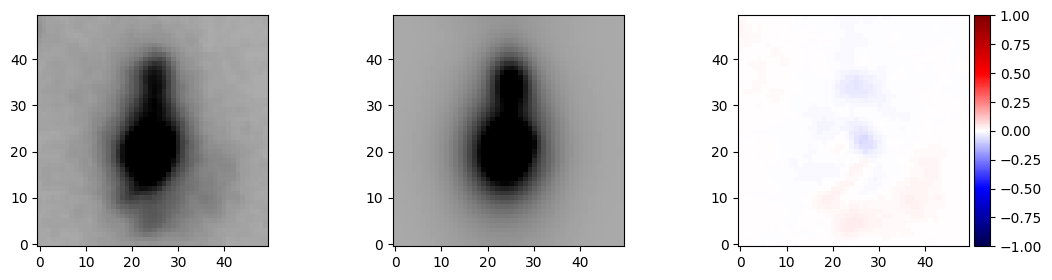

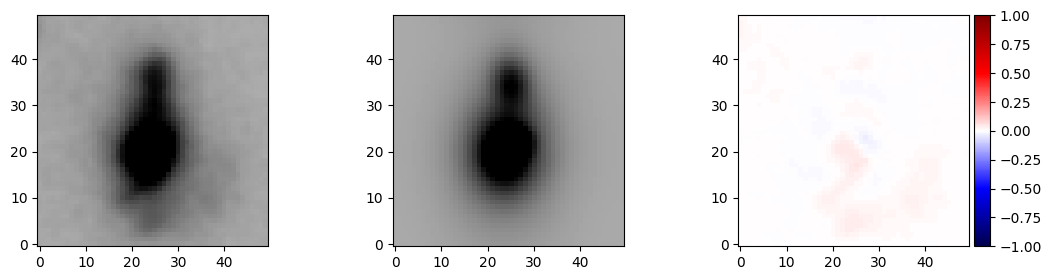

In [17]:
summ_link = az.summary(multires.idata, var_names=link_params)
summ_const = az.summary(multires.idata, var_names=const_params)
summ_flux = az.summary(multires.idata, var_names=flux_params)
for j in filter_list:
    dict_link = {}
    dict_const = {}
    dict_flux = {}
    for a, b in zip(summ_link.index, summ_link["mean"]):
        dict_link[a] = b
    for a, b in zip(summ_const.index, summ_const["mean"]):
        dict_const[a] = b
    for a, b in zip(summ_flux.index, summ_flux["mean"]):
        dict_flux[a] = b

    dict_0 = {'xc': dict_const['xc_0'], 
        'yc': dict_const['yc_0'], 
        'r_eff': dict_link[f'r_eff_0_{j}'],
        'n': dict_link[f'n_0_{j}'], 
        'ellip': dict_link[f'ellip_0_{j}'], 
        'flux': dict_flux[f'flux_0_{j}'], 
        'theta': dict_const[f'theta_0'],
        'f_1': 1}

    dict_1 = {'xc': dict_const['xc_1'], 
        'yc': dict_const['yc_1'], 
        # 'r_eff': dict_link[f'r_eff_2_{j}'],
        # 'n': dict_link[f'n_2_{j}'], 
        # 'ellip': dict_link[f'ellip_2_{j}'], 
        'flux': dict_flux[f'flux_1_{j}'], 
        # 'theta': dict_const[f'theta_2'],
        'f_1': 1}

    dict_2 = {'xc': dict_const['xc_2'], 
        'yc': dict_const['yc_2'], 
        'r_eff': dict_link[f'r_eff_2_{j}'],
        'n': dict_link[f'n_2_{j}'], 
        'ellip': dict_link[f'ellip_2_{j}'], 
        'flux': dict_flux[f'flux_2_{j}'], 
        'theta': dict_const[f'theta_2'],
        'f_1': 1}


    # dict.pop('sys_scatter')
    bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
    bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
    bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')

    bf_model = bf_model0 + bf_model1 + bf_model2

    fig, ax = plot_residual(im, bf_model, mask = mask, vmin=-1, vmax=1)
    plt.show()

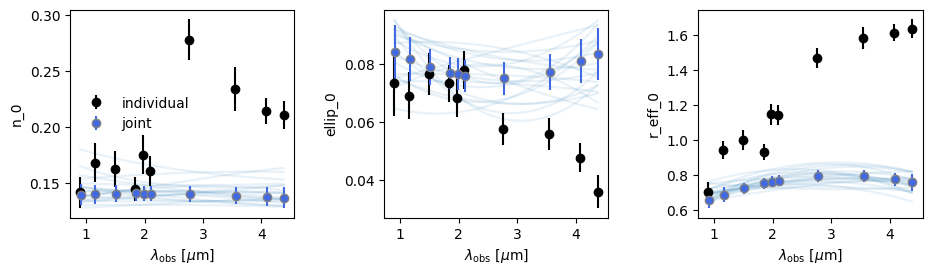

In [20]:
# plot results 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 2.7))

titles = ["Sersic index n", "ellipticity", r"$R_{\rm eff}$ [kpc]"]

# for j, param in enumerate(['n_0', 'n_2', 'n_3', 'ellip_0', 'ellip_2', 
#                                'ellip_3', 'r_eff_0', 'r_eff_2', 'r_eff_3']):
for j, param in enumerate(['n_0', 'ellip_0', 'r_eff_0']):
    ax = axes[j]

    med_ind = np.array([ind_res_dict[b][param][0] for b in band_list])
    err_ind = np.array([ind_res_dict[b][param][1] for b in band_list])
    
    med_multi = np.array([multi_res_dict[f'{param}_{b}'][0] for b in band_list])
    err_multi = np.array([multi_res_dict[f'{param}_{b}'][1] for b in band_list])


    if (param == 'r_eff_0', 'r_eff_2'):
        conversion = kpc_per_arcsec*pix_scale
    else:
        conversion = 1.0
    
    param_smooth = multires.idata.posterior[f'{param}_at_wv'].data.squeeze()
    ax.plot(wv_to_save, conversion*param_smooth[:20].T, '-', color='C0', alpha = 0.1)
    ax.errorbar(wv_list, conversion*med_ind, yerr=conversion*err_ind, fmt = 'o', color = 'k', label = 'individual')
    ax.errorbar(wv_list+0.01, conversion*med_multi, yerr=conversion*err_multi, fmt = 'o', color = 'royalblue', markeredgecolor='gray', label = 'joint')

    ax.set_xlabel(r'$\lambda_{\rm obs}$ [$\mu$m]')
    # ax.set_xlim([1, 5])
    # ax.set_ylabel(titles[j])
    ax.set_ylabel(param)

# axes[0].set_ylim([0.5, 1.5])
# axes[1].set_ylim([0.3, 0.6])
# axes[2].set_ylim([0.5, 2])
axes[0].legend(frameon=False)

# axes[0].tick_params(width=1.5, length=7)
# plt.setp(axes[0].spines.values(), lw=1.5)
# axes[1].tick_params(width=1.5, length=7)
# plt.setp(axes[1].spines.values(), lw=1.5)
# axes[2].tick_params(width=1.5, length=7)
# plt.setp(axes[2].spines.values(), lw=1.5)

plt.subplots_adjust(wspace=0.4, hspace=0.05)
# plt.savefig(path_wdir + '2nd_multi_1comp.pdf', bbox_inches='tight')
plt.show()


In [16]:
# extract best fit and save

ind_fit = {}
joint_fit = {}
ind_err_fit = {}
joint_err_fit = {}

for j,param in enumerate(['flux', 'n', 'ellip', 'r_eff']):

    ind_fit[param] = [ind_res_dict[b][param][0] for b in band_list]
    ind_err_fit[param] = [ind_res_dict[b][param][1] for b in band_list]

    joint_fit[param] = [multi_res_dict[f'{param}_{b}'][0] for b in band_list]
    joint_err_fit[param] = [multi_res_dict[f'{param}_{b}'][1] for b in band_list]


In [ ]:
# ?
param = 'ellip'
conv = 1.0 #kpc_per_arcsec*pix_scale
print(conv*np.round(ind_fit[param],2), conv*np.round(ind_err_fit[param],2))
print(conv*np.round(joint_fit[param],2), conv*np.round(joint_err_fit[param],2))


### Double Component

In [ ]:
wv_to_save = np.linspace(min(wv_list),max(wv_list), num = 50)

# double component
MultiFitter = FitMultiBandPoly(fitter_list=[fitter2_dict[b] for b in band_list],
                               wavelengths=wv_list,
                               band_names= band_list,
                               linked_params=['f_1'],
                               const_params=['xc','yc','n','theta','r_eff_1','ellip_1','r_eff_2','ellip_2'],
                               wv_to_save= wv_to_save,
                               poly_order = 2)
rkey,_ = jax.random.split(rkey,2)
multires = MultiFitter.estimate_posterior(method = 'svi-flow', rkey = rkey)

link_params = [f'{param}_{b}' for b in band_list for param in ['f_1']] # Look at posteriors of "linked" parameters
multi2_res_dict = multires.retrieve_med_std()
az.summary(multires.idata, var_names=link_params)


In [ ]:
az.summary(multires.idata, var_names=['n', 'r_eff_1','r_eff_2'])


In [ ]:
print("1st Comp (bulge) Re:", 4.899*kpc_per_arcsec*pix_scale, "+/-", 0.082*kpc_per_arcsec*pix_scale)
print("2nd Comp (disc) Re:", 10.421*kpc_per_arcsec*pix_scale, "+/-", 0.117*kpc_per_arcsec*pix_scale)

In [ ]:
titles = ["B/T"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.7))

for j, param in enumerate(['f_1']):
    ax = axes

    med_ind = np.array([ind2_res_dict[b][param][0] for b in band_list])
    err_ind = np.array([ind2_res_dict[b][param][1] for b in band_list])

    med_multi = np.array([multi2_res_dict[f'{param}_{b}'][0] for b in band_list])
    err_multi = np.array([multi2_res_dict[f'{param}_{b}'][1] for b in band_list])

    if (param == 'r_eff_1') | (param == 'r_eff_2'):
        conversion = kpc_per_arcsec*pix_scale
    else:
        conversion = 1.0
    
    param_smooth = multires.idata.posterior[f'{param}_at_wv'].data.squeeze()
    ax.plot(wv_to_save, conversion*param_smooth[:20].T, '-', color='C0', alpha = 0.1)
    ax.errorbar(wv_list, conversion*med_ind, yerr=conversion*err_ind, fmt = 'o', color = 'k', label = 'individual')
    ax.errorbar(wv_list+0.01, conversion*med_multi, yerr=conversion*err_multi, fmt = 'o', color = 'royalblue', markeredgecolor='gray', label = 'joint')
    # ax.set_title(param, fontsize = 14)
    ax.set_xlabel(r'$\lambda_{\rm obs}$ [$\mu$m]')
    # ax.set_xlim([1, 5])
    ax.set_ylabel(titles[j])

# axes.set_ylim([0.0, 1])
axes.legend(frameon=False)

axes.tick_params(width=1.5, length=7)
plt.setp(axes.spines.values(), lw=1.5)
# plt.title('Multi-band fitting, double component', pad = 15)

# plt.subplots_adjust(wspace=0.8, hspace=0.07)
plt.savefig(path_wdir + 'looser_multi_2comp.pdf', bbox_inches='tight')
plt.show()


In [22]:
# extract best fit and save

ind2_fit = {}
joint2_fit = {}
ind2_err_fit = {}
joint2_err_fit = {}

for j,param in enumerate(['f_1', 'flux']):

    ind2_fit[param] = [ind2_res_dict[b][param][0] for b in band_list]
    ind2_err_fit[param] = [ind2_res_dict[b][param][1] for b in band_list]

    joint2_fit[param] = [multi2_res_dict[f'{param}_{b}'][0] for b in band_list]
    joint2_err_fit[param] = [multi2_res_dict[f'{param}_{b}'][1] for b in band_list]

